# Step 0: Basic Imports

In [3]:
from __future__ import print_function

import torch
import torch.nn
import torch.nn.functional
import torch.optim
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
import sys
import os
import cv2

# KeOps kernels
!pip install -q pykeops[colab] > install.log
from pykeops.torch import Genred

# pytorch version of np.Interp, which is used for histogram loss
!pip install -q git+https://github.com/aliutkus/torchinterp1d.git
from torchinterp1d import Interp1d

%pylab inline

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Populating the interactive namespace from numpy and matplotlib
cuda


# Step 1: Image Loader

loading an RGB image, tiling it by (3, 3)
loading an L image, tiling it by (1, 1)
torch.Size([1, 3, 256, 409])


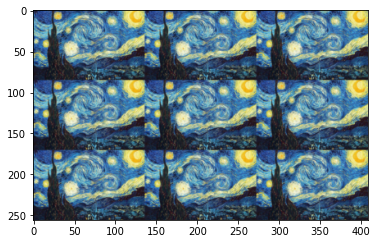

torch.Size([1, 3, 256, 256])


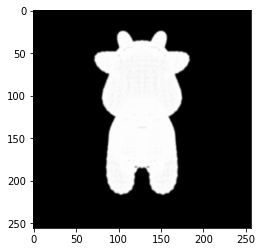

In [4]:
cnn_norm_mean = [0.485, 0.456, 0.406]
cnn_norm_std = [0.229, 0.224, 0.225]

cnn_norm_back_mean= [-0.485/0.229, -0.456/0.224, -0.406/0.225]
cnn_norm_back_std= [1/0.229, 1/0.224, 1/0.225]

def image_loader(image_name, imsize = None, tiling = (1,1), mask = False):
    image = Image.open(image_name)

    tiling = (tiling, tiling) if isinstance(tiling, int) else tiling
    print("loading an " + image.mode + " image, tiling it by", tiling)

    if tiling != (1,1) and image.mode == 'RGB':
        width_repeat = tiling if isinstance(tiling, int) else tiling[0]
        height_repeat = tiling if isinstance(tiling, int) else tiling[1]
        tiled_image = Image.new('RGB', (image.width * width_repeat, image.height * height_repeat))
        for width_offset in range (0, image.width * width_repeat, image.width):
            for height_offset in range (0, image.height * height_repeat, image.height):
                tiled_image.paste(image, (width_offset, height_offset))
        image = tiled_image
    
    if imsize is None:
        loader_help = transforms.ToTensor()
    else:
        loader_help = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
        
    image = loader_help(image)
    
    # when loading silhouette/grayscale image, duplicate for RGB channels
    if image.shape[0] == 1 and not mask:
        image = image.repeat(3,1,1)
    
    # pre-processing
    if not mask:
        image = transforms.Normalize(mean=cnn_norm_mean, std=cnn_norm_std)(image)
        image = image.unsqueeze(0)                                          
    
    return image.to(device, torch.float)


def image_unloader(tensor):
    tensor = tensor.data[0].cpu()
    unloader_help = transforms.Normalize(mean=cnn_norm_back_mean, std=cnn_norm_back_std)
    t = unloader_help(tensor)
    t.clamp_(0, 1)
    img = transforms.Compose([transforms.ToPILImage()])(t)
    return img


style_img = image_loader("./image_style/starry_night.jpg", imsize=256, tiling=(3,3))
content_img = image_loader("./image_content/sil_cow_grayscale.png", imsize=256, tiling=(1,1))

print(style_img.shape)
imshow(image_unloader(style_img));show()
print(content_img.shape)
imshow(image_unloader(content_img))

# Step 2: Content Loss

In [5]:
class ContentLoss(torch.nn.Module):

    def __init__(self, target_content):
        super(ContentLoss, self).__init__()
        # detach the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target_content = target_content.detach()
         
    # the ContentLoss layer is somehow "transparent" to the whole network,
    # as the forword method returns its input as output directly
    def forward(self, input):
        self.loss = torch.nn.functional.mse_loss(input, self.target_content)
        return input

# Step 3: Style Loss

## Mask Layer

In [6]:
## A very simple layer which just stores input at forward
class DownSampleMask(torch.nn.Module):
    def __init__(self):
        super(DownSampleMask, self).__init__()
    
    def forward(self, input):
        self.mask = input.detach()
        return input

## Gram Matrix

In [7]:
def gram_matrix(input):
    ###################################################################
    # The pytorch tutorial makes a great mistake here on normalization
    # Here, already the version corrected by Mengdi
    ###################################################################
    
    # h * w should equal to input.shape[1]
    hw = input.shape[1]
    G = torch.mm(input, input.transpose(0,1))  # compute the gram product 
    G.div_(hw)

    return G

## Batch Normalization Mean and Std

In [8]:
def BN_mean_and_std(input):
    mean = input.mean(1)
    std  = input.std(1)
    return mean, std

## Histogram Loss

In [9]:
def hisgram_loss(input_feature_normalized, style_feature_normalized_ordered, style_quantiles):    
    c = input_feature_normalized.shape[0]   # c: number of channels
    histo_losses = 0
    for feature, s_ordered, s_quantiles in zip(input_feature_normalized, style_feature_normalized_ordered, style_quantiles):
        _, bin_idx, i_counts = feature.unique(return_inverse=True, return_counts=True, sorted=True)
        i_quantiles = torch.cumsum(i_counts, dim=0, dtype=torch.float32)
        i_quantiles = i_quantiles / i_quantiles[-1]
        
        # histogram match
        # in case there is only one unique value in feature
        if len(i_counts) == 1 or len(s_quantiles) == 1:
            matched_feature = torch.full_like(bin_idx, s_ordered.mean(), dtype=torch.float32) 
        else:
            matched_feature = Interp1d()(s_quantiles, s_ordered, i_quantiles)[0][bin_idx]
            
        # histogram loss
        histo_loss = torch.nn.functional.mse_loss(feature, matched_feature)
        histo_losses += histo_loss

    return histo_losses / c

## Kernel

Details in https://www.kernel-operations.io/keops/api/math-operations.html

In [10]:
# kernels from KeOps print too much... with the following function kernels can run silently
class NoStdStreams(object):
    def __init__(self,stdout = None, stderr = None):
        self.devnull = open(os.devnull,'w')
        self._stdout = stdout or self.devnull or sys.stdout
        self._stderr = stderr or self.devnull or sys.stderr
    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr
    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr
        self.devnull.close()


# kernel formulas
formulas = {'linear': '(x | y)',                # or '(x | y) + p' 
            'poly'  : 'Square((x | y))',        # or 'Pow((x | y) + c, 2)' , which is slower than Square    
            'rbf'   : 'Exp(-p * SqDist(x , y))',
            'dist'  : 'SqDist(x , y)'
            }

# formula parameters
# !!! VGG has only 4 different #channels: 64, 128, 256, 512
formula_paras  = {64:  ['p = Pm(1)', 'x = Vi(64)',  'y = Vj(64)'],
                  128: ['p = Pm(1)', 'x = Vi(128)', 'y = Vj(128)'],
                  256: ['p = Pm(1)', 'x = Vi(256)', 'y = Vj(256)'],
                  512: ['p = Pm(1)', 'x = Vi(512)', 'y = Vj(512)']
                  }

# the dictionary kernels contain all kernel functions. It has keys 'linear', 'poly' and 'rbf',
# and the value to a key is also a dictionary, with number of channel as key (64, 128, 256, 512)
kernels = {}

for formula in formulas:
    kernels[formula] = {}
    for n_channel in formula_paras:
        kernels[formula][n_channel] = Genred(formulas[formula],
                                             formula_paras[n_channel],
                                             reduction_op = 'Sum',
                                             # axis = 0 or 1
                                             )

# Problem: KeOps requires gradients to be contiguous
# Solution: https://github.com/getkeops/keops/issues/30#issuecomment-540009963
# Function to ensure contiguous gradient in backward pass. To be applied after PyKeOps reduction.
class ContiguousBackward(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return input

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.contiguous()

# self-defined mean reduction of kernel
def kernel_mean(kernel, p, x, y):
    with NoStdStreams():
        # mean_xx = ContiguousBackward().apply(kernel(p, x, x)).sum()/(x.shape[0]**2)
        mean_yy = ContiguousBackward().apply(kernel(p, y, y)).sum()/(y.shape[0]**2)
        mean_xy = ContiguousBackward().apply(kernel(p, x, y)).sum()/(x.shape[0] * y.shape[0])
    # mean_xx has actually nothing to do with input image
    # return mean_xx + mean_yy - 2 * mean_xy
    return mean_yy - 2 * mean_xy

# self-defined mean distance
def mean_square_distance(c, x, y):
    kernel = kernels['dist'][c]
    with NoStdStreams():
        dist = kernel(torch.tensor([0.]).to(device), x, y).sum()
    return (dist/(x.shape[0]*y.shape[0])).detach()

## Style Loss Layer

In [11]:
# stabilization for division with denominator 0
eps = 1e-5

class StyleLoss(torch.nn.Module):

    def __init__(self, target_style, style_loss_types, mask_layer, masking = False):
        super(StyleLoss, self).__init__()

        # mask
        self.mask_layer = mask_layer
        self.masking = masking

        # b: batch size, which should be 1
        # c: number of channels
        # h: height
        # w: width
        b, c, h, w = target_style.size()
        print("c:", "{:3d}".format(c), "  h:", "{:3d}".format(h), "  w:", "{:3d}".format(w))
        style_feature = target_style.view(c, h * w)
        
        self.use_gram   = 'gram'   in style_loss_types
        self.use_bnst   = 'bnst'   in style_loss_types
        self.use_morest = 'morest' in style_loss_types
        self.use_histo  = 'histo'  in style_loss_types
        self.use_kernel = 'linear' in style_loss_types or 'poly' in style_loss_types or 'rbf' in style_loss_types

        # gram matrix 
        if self.use_gram:
            self.target_gram_matrix = gram_matrix(style_feature).detach()
        
        # mean and std   
        if self.use_bnst:
            self.target_mean, self.target_std = BN_mean_and_std(style_feature)
            self.target_mean.detach_()
            self.target_std.detach_()
        
        # more statistical loss
        if self.use_morest:
            self.target_c_std = target_style[0].std(0)#.mean()
            self.target_h_std = target_style[0].std(1)#.mean(1)
            self.target_w_std = target_style[0].std(2)#.mean(1)
        
        # histogram loss
        if self.use_histo:
            # normalize features to range (0, 1)
            style_feature_normalized = (style_feature - style_feature.min(1)[0][:, None]) / (eps + style_feature.max(1)[0][:, None] - style_feature.min(1)[0][:, None])
            
            # match histogram, reference https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x/33047048#33047048
            self.style_ordered = []
            self.style_quantiles = []
            for feature in style_feature_normalized:
                s_ordered, s_counts = feature.unique(return_counts=True, sorted=True)
                s_quantiles = torch.cumsum(s_counts, dim=0, dtype=torch.float)
                s_quantiles = s_quantiles / s_quantiles[-1]
                self.style_ordered.append(s_ordered.detach())
                self.style_quantiles.append(s_quantiles.detach())
        
        # kernels
        if self.use_kernel:
            # tranpose
            self.transposed_style = style_feature.transpose(0, 1).contiguous().detach()
            
            # kernel names and weights
            self.kernel_names = []
            for name in ['linear', 'poly', 'rbf']:
                if name in style_loss_types:
                    self.kernel_names.append(name)
                    
            # self.rbf_p = torch.tensor([1/((self.transposed_style**2).sum(1).mean())]).detach().to(device)


    ####################################### forward #######################################
    def forward(self, input):
        b, c, h, w = input.size()     # b = 1 since there is only one image in batch

        # masking feature
        input_masked = input * self.mask_layer.mask if self.masking else input

        input_feature = input_masked.view(c, h * w)

        # losses is a dictionary of name: value
        self.losses = {}

        # gram matrix loss
        if self.use_gram:
            input_gram_matrix = gram_matrix(input_feature)
            self.losses['gram'] = torch.nn.functional.mse_loss(input_gram_matrix, self.target_gram_matrix)
        
        # mean and std loss   
        if self.use_bnst:
            input_mean, input_std = BN_mean_and_std(input_feature)
            mean_loss = torch.nn.functional.mse_loss(input_mean, self.target_mean)
            std_loss  = torch.nn.functional.mse_loss(input_std, self.target_std)
            self.losses['bnst'] = mean_loss + std_loss

        # loss based on more statistics
        if self.use_morest:    
            input_feature_m = input_feature.view(c, h, w)
            input_c_std = input_feature_m.std(0)
            input_h_std = input_feature_m.std(1)
            input_w_std = input_feature_m.std(2)
            c_loss = torch.nn.functional.mse_loss(self.target_c_std, input_c_std)
            h_loss = torch.nn.functional.mse_loss(self.target_h_std, input_h_std)
            w_loss = torch.nn.functional.mse_loss(self.target_w_std, input_w_std)
            self.losses['morest'] = h_loss + w_loss + c_loss 
        
        # histogram loss
        if self.use_histo:
            # normalize features to range (0, 1)
            input_feature_normalized = (input_feature - input_feature.min(1)[0][:, None]) / (eps + input_feature.max(1)[0][:, None] - input_feature.min(1)[0][:, None])
            
            self.losses['histo'] = hisgram_loss(input_feature_normalized, self.style_ordered, self.style_quantiles)
        
        # kernel loss 
        if self.use_kernel:
            # transposed input feature
            tranposed_input = input_feature.transpose(0, 1).contiguous()

            for k_name in self.kernel_names:
                p = torch.tensor([0.]).to(device) if k_name != 'rbf' else 1/torch.tensor([mean_square_distance(c, self.transposed_style, tranposed_input)]).to(device)
                self.losses[k_name] = kernel_mean(kernels[k_name][c], p, self.transposed_style, tranposed_input)/(c**2)
        
        
        
        return input

# Step 4: VGG

In [12]:
# Pytorch model can be divided into two parts: features(conv and pooling layers) and classifier(fc layers)

cnn = models.vgg19(pretrained=True).features.to(device).eval()

print(cnn)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Step 5: Model Definition

In [13]:
# !!! The pytorch tutorial for neural style transfer makes a great mistake in model definition !!!

# desired depth layers to compute style/content losses :
style_layers_default = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
content_layers_default = ['conv4_2']

#####################################################################################
# Accoring to the Gatys' raw implementation, the actual desired layers are not convs,
# rather activated convs, i.e. output from relu layers.
#####################################################################################
print("The desired content layers are: ", content_layers_default)
print("But the truely needed are     : ", [x.replace('conv', 'relu') for  x in content_layers_default])
print()
print("The desired style layers are  : ", style_layers_default)
print("But the truely needed are     : ", [x.replace('conv', 'relu') for  x in style_layers_default])

def get_models_losses_masks(cnn,
                            style_img,
                            content_img,
                            style_layers = style_layers_default,
                            content_layers = content_layers_default,
                            style_loss_types = {'gram':1},
                            need_content = False,
                            masking = False,
                            model_pooling = 'max',
                            mask_pooling = 'avg',
                            silent = True):

    # model for masks
    model_mask = torch.nn.Sequential()
    mask_layers = []
    first_layer = DownSampleMask()
    model_mask.add_module('mask_1', first_layer)
    mask_layers.append(first_layer)
    for i in range(4):
        if mask_pooling == 'max':
            layer = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        elif mask_pooling =='avg':
            layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            raise RuntimeError("Pooling must be either max or avg! But now it is:" + mask_pooling)
        
        # add pooling layer
        model_mask.add_module(mask_pooling + '_pooling_' + str(i+1), layer)

        # add mask layer
        get_input_layer = DownSampleMask()
        model_mask.add_module('mask_' + str(i+2), get_input_layer)
        mask_layers.append(get_input_layer)
    
    # model for style
    style_losses = []
    style_layers   = [x.replace('conv', 'relu') for  x in style_layers]
    model_style   = torch.nn.Sequential()

    # model for content
    # independent models for computing content loss and style loss
    # benefits: content image and style image can be in different sizes
    content_losses = []
    content_layers = [x.replace('conv', 'relu') for  x in content_layers]
    model_content = torch.nn.Sequential()
    

    #####################################################################
    # For the following part, the pytorch tutorial makes great mistakes.
    # Currently already corrected by Mengdi
    #####################################################################
    conv_i = 1
    relu_i = 1
    pool_i = 1    # pool_i is important since conv blocks are separated by pooling layers
    bn_i = 1
    
    for layer in cnn.children():
        if isinstance(layer, torch.nn.Conv2d):
            name = 'conv{}_{}'.format(pool_i, conv_i)
            conv_i += 1
        elif isinstance(layer, torch.nn.ReLU):
            name = 'relu{}_{}'.format(pool_i, relu_i)
            layer = torch.nn.ReLU(inplace=False) # in-place ReLU doesnt work well
            relu_i += 1
        elif isinstance(layer, torch.nn.BatchNorm2d):
            name = 'bn{}_{}'.format(pool_i, bn_i)
            bn_i += 1
        elif isinstance(layer, torch.nn.MaxPool2d):
            name = 'pool{}'.format(pool_i)
            if model_pooling == 'max':
                layer = torch.nn.MaxPool2d(kernel_size=2, stride=2)
            elif model_pooling == 'avg':
                layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
            else:
                raise RuntimeError("Pooling must be either max or avg! But now it is:" + model_pooling)
            pool_i += 1
            conv_i = 1
            relu_i = 1
            bn_i = 1  
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))


        model_style.add_module(name, layer)
        model_content.add_module(name, deepcopy(layer))


        # add style layers
        if name in style_layers:
            target_style = model_style(style_img).detach()
            style_loss = StyleLoss(target_style, style_loss_types, mask_layers[pool_i-1], False)
            model_style.add_module("style_loss_{}_{}".format(pool_i, relu_i-1), style_loss)
            style_losses.append(style_loss)
        
        # add content layers
        if name in content_layers:
            target_content = model_content(content_img).detach()
            content_loss = ContentLoss(target_content)
            model_content.add_module("content_loss_{}_{}".format(pool_i, relu_i-1), content_loss)
            content_losses.append(content_loss)


    # trim off the layers after the last content and style losses
    for i in range(len(model_style) - 1, -1, -1):
        if isinstance(model_style[i], StyleLoss): # or isinstance(model_content[i], ContentLoss):
            break
    
    for j in range(len(model_content) - 1, -1, -1):
        if isinstance(model_content[j], ContentLoss): # or isinstance(model_style[j], StyleLoss):
            break
        
    model_style   = model_style  [:(i + 1)]
    model_content = model_content[:(j + 1)]
    
    # set self.masking to True if masking. This has to be done afterwards, otherwise model build 
    # may fail because style image and mask image are not necessary of same size
    for l in style_losses:
        l.masking = masking

    if not silent:
        print()
        print("Style model is as follow:")
        print(model_style)
        print()
        
        if need_content:
            print("Content model is as follow:")
            print(model_content)
        
    return model_style, model_content, model_mask, style_losses, content_losses

The desired content layers are:  ['conv4_2']
But the truely needed are     :  ['relu4_2']

The desired style layers are  :  ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
But the truely needed are     :  ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1']


# Step 6: Optimizer

In [14]:
# why LBFGS?
# https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq

learning_rate = 1

def get_input_optimizer(input_img, lr=learning_rate):
    # this line to show that input is a parameter that requires a gradient
    optimizer = torch.optim.LBFGS([input_img], lr=lr) #LBFGS([input_img], lr=lr)
    return optimizer

# Step 7: (obsolete) Soft Mask

In [15]:
def old_soft_mask(silhouette_path = "./drive/MyDrive/image_content/sil_cow_grayscale.png", 
                  silhouette_size = (512,512), 
                  threshold = 0,
                  power = 16):
        
    sil_grayscale = cv2.imread("./drive/MyDrive/image_content/sil_cow_grayscale.png", cv2.IMREAD_GRAYSCALE)
    
    # silhouette_size is (height, width), but cv2.resize works on (width, height)
    sil_grayscale = cv2.resize(sil_grayscale, (silhouette_size[1], silhouette_size[0]))
    
    # all pixels with value greater than threshold are set to 255
    sil_grayscale = cv2.threshold(sil_grayscale, threshold, 255, cv2.THRESH_BINARY)[1]
    
    # inverse silhouette, previously object is with pixel value 255, now with value 0
    sil_grayscale = 255 - sil_grayscale

    # distance of each pixel to the closet 0 valued pixel
    distance_to_zero = cv2.distanceTransform(sil_grayscale, cv2.DIST_L2, 3)
    
    # normalize
    distance_to_zero = distance_to_zero / distance_to_zero.max()

    # inverse again, now object is with pixel value 1.0, and background pixel value is higher when closer to object     
    distance_to_zero = 1-distance_to_zero

    # clip value between 0 and 1
    distance_to_zero = np.clip(distance_to_zero, 0., 1.)

    # power
    distance_to_zero = distance_to_zero**power

    # clip again
    distance_to_zero = np.clip(distance_to_zero, 0., 1.)

    # depulicate tensor
    soft_mask_tensor = torch.tensor(distance_to_zero).repeat(3,1,1).unsqueeze(0)

    return soft_mask_tensor.detach().to(device)

# Step 8: Pipeline

In [16]:
def run_style_transfer(cnn,
                       style_img,
                       content_img,  
                       input_img, 
                       mask_img,
                       n_iters,
                       style_weights,
                       content_weights,
                       style_layers = style_layers_default, 
                       content_layers = content_layers_default,
                       style_loss_types = {'gram': 1}, 
                       learning_rate = 1,
                       need_content = False,
                       masking = False,
                       model_pooling = 'max',
                       mask_pooling = 'avg',
                       silent = True):
    # Run the style transfer
    if not silent:
        print('Building the style transfer model..')
        print()

    
    if 'morest' in style_loss_types and style_img.shape[-2:] != input_img.shape[-2:]:
        raise RuntimeError("Style image " + str(style_img.shape[-2:]) + " and input image " + str(input_img.shape[-2:]) + " not of same size!")

    if masking and input_img.shape[-2:] != mask_img.shape[-2:]:
        raise RuntimeError("Input image " + str(input_img.shape[-2:]) + " and mask image " + str(mask_img.shape[-2:]) + " not of same size!")

    # get style and content models        
    model_style, model_content, model_mask, style_losses, content_losses = get_models_losses_masks(cnn,
                                                                                                   style_img,
                                                                                                   content_img,
                                                                                                   style_layers = style_layers,
                                                                                                   content_layers = content_layers,
                                                                                                   style_loss_types = style_loss_types,
                                                                                                   need_content = need_content,
                                                                                                   masking = masking,
                                                                                                   model_pooling = model_pooling,
                                                                                                   mask_pooling = mask_pooling,
                                                                                                   silent = silent)
    
    # optimize the input and not the model parameters, so update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model_style.requires_grad_(False)
    model_content.requires_grad_(False)

    # optimizer
    optimizer = get_input_optimizer(input_img, lr=learning_rate)

    # loss history
    loss_history = {name: {'weight':weight, 'values':[]} for name, weight in style_loss_types.items()}
    if need_content:
        loss_history['content'] = {'weight': 1., 'values':[]}

    if not silent:
        print()
        print('Optimizing..')
    run = [0]
    while run[0] <= n_iters:

        def closure():
            # with torch.no_grad():
                # input_img.clamp_(eps, one)
            
            optimizer.zero_grad()

            # forward pass
            if masking:     # first, update mask
                model_mask(mask_img)
            model_style(input_img)
            
            # a dictionary saves style losses at this iteration
            loss_current_iter = {name: 0 for name in style_loss_types}
            
            # compute style loss
            for sl, sl_weight in zip(style_losses, style_weights):
                for name in style_loss_types:
                    loss_current_iter[name] += sl.losses[name] * sl_weight * style_loss_types[name]
            
            # total style loss
            style_score = 0
            for v in loss_current_iter.values():
                style_score += v
            
            # compute content loss
            if need_content:
                model_content(input_img)
                loss_current_iter['content'] = 0
                for cl, cl_weight in zip(content_losses, content_weights):
                    loss_current_iter['content'] += cl.loss * cl_weight
            
            # total loss (style + content)
            all_score = style_score + loss_current_iter['content'] if need_content else style_score
            
            # add current iter loss to history
            for name, value in loss_current_iter.items():
                loss_history[name]['values'].append(value.detach().cpu())
            
            # run KeOps kernels silently
            with NoStdStreams():
                all_score.backward()

            run[0] += 1
            if run[0] % 20 == 0:
                print("run {}:".format(run))
                if not silent:
                    if need_content:
                        print('Style Loss : {:.4f} Content Loss: {:.4f}'.format(style_score.item(), loss_current_iter['content'].item()))
                    else:
                        print('Style Loss : {:.4f}'.format(style_score.item()))
                    print()

            if need_content:
                return all_score
            else:
                return style_score

        optimizer.step(closure)


    # with torch.no_grad():
        # input_img.clamp_(0, 1)

    return input_img, loss_history

# Step 9: Loss Plot

In [17]:
# Plot losses as a function of optimization iteration
def plot_losses(losses, save_plot=True, loss_name = None, start = 0, end = None):
    if end is None:
        end = len(losses.values[0]['values'])
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()

    # when loss_name is None, plot all loses
    if loss_name is None:
        for k, l in losses.items():
            ax.plot(l['values'][start:end], label= k + " loss, weight " + str(l['weight']))
    else:
        k = loss_name
        l = losses[k]
        ax.plot(l['values'][start:end], label= k + " loss, weight " + str(l['weight']))
    ax.legend(fontsize="16")
    # ax.set_xlim([start, end])
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Weighted Loss", fontsize="16")
    ax.set_title("Weighted Loss vs Iterations", fontsize="16")
    if save_plot:
        plt.savefig("loss_plot.png")

# Step 10: Run

loading an RGB image, tiling it by (3, 3)
loading an L image, tiling it by (1, 1)
loading an L image, tiling it by (1, 1)
Building the style transfer model..

c:  64   h: 512   w: 819
c: 128   h: 256   w: 409
c: 256   h: 128   w: 204
c: 512   h:  64   w: 102

Style model is as follow:
Sequential(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (style_loss_1_1): StyleLoss(
    (mask_layer): DownSampleMask()
  )
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (style_loss_2_1): StyleLoss(
    (mask_layer): DownSampleMask()
  )
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

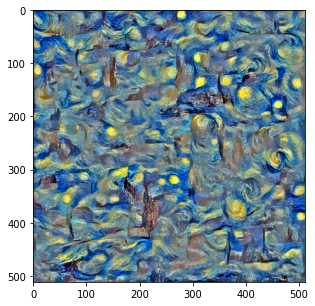

In [18]:
# in case of style/content reconstruction, just set the corresponding weights to 0 and use white noise input
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
content_layers = ['conv4_2']
style_weights = [1e6/n**2 for n in [64,128,256,512]]
content_weights = [1]
model_pooling = 'max'
mask_pooling = 'avg'
n_iters = 300
learning_rate = 1

# which style losses are considered (and their weights)?
# 'gram', 'bnst', 'morest', 'linear', 'poly', 'rbf' ('linear', 'poly' and 'rbf' are kernels)
# 'gram'  : style loss based on gram matrix
# 'bnst' : style loss based on BN mean and std
# 'morest': style loss based on more statistics (row-wise and column-wise std)
style_loss_types = {'gram':1,
                    #'bnst':1,
                    #'morest':1e-1,
                    #'histo':1,
                    #'linear':1,
                    #'poly':1,
                    #'rbf':1e2,
                    }

# images
style_img = image_loader("./image_style/starry_night.jpg", imsize=512, tiling=(3,3))

content_img = image_loader("./image_content/sil_cow_grayscale.png", imsize=512)
need_content = False

# input_img = torch.randn(style_img.shape, device=device)
input_img = torch.rand(content_img.shape, device=device)
# input_img = content_img.clone().to(device)

# mask_img = old_soft_mask("./drive/.MyDrive/image_content/sil_cow_grayscale.png", input_img.shape[-2:])
mask_img = image_loader("./image_content/sil_cow_grayscale.png", input_img.shape[-2:], mask = True)
masking = False
output_img, loss_history = run_style_transfer(cnn = cnn, 
                                              style_img = style_img, 
                                              content_img = content_img,
                                              input_img = input_img,
                                              mask_img = mask_img,
                                              n_iters = n_iters,
                                              style_weights = style_weights,
                                              content_weights = content_weights,
                                              style_layers = style_layers,
                                              content_layers = content_layers,
                                              style_loss_types = style_loss_types,
                                              learning_rate = learning_rate,
                                              need_content = need_content,
                                              masking = masking,
                                              model_pooling = model_pooling,
                                              mask_pooling = mask_pooling,
                                              silent = False)
 

imshow(image_unloader(output_img))
gcf().set_size_inches(5,5)

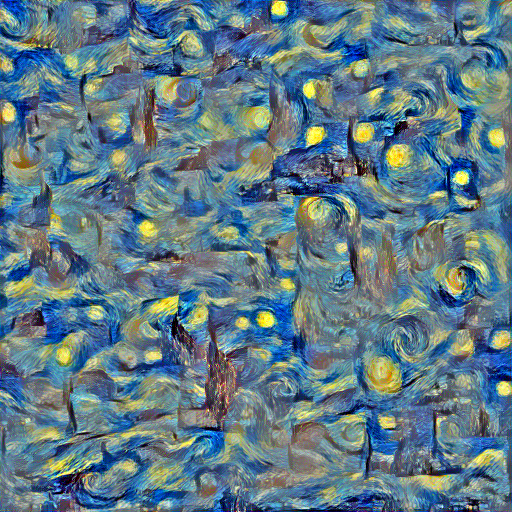

In [19]:
image_unloader(output_img)

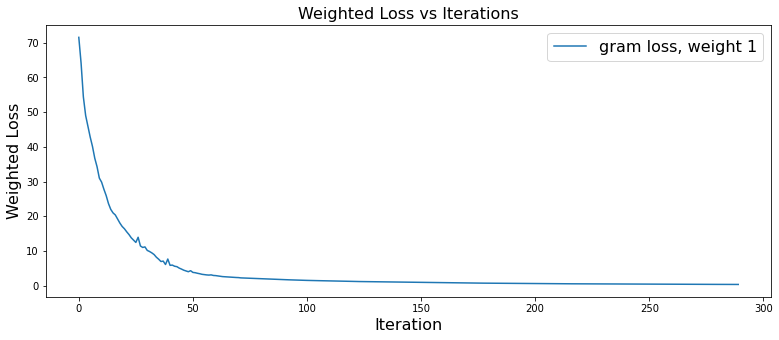

In [20]:
# plot loss
plot_losses(loss_history, loss_name = None, start = 10, end = n_iters)